In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
from datetime import datetime
import warnings
import spacy
from huggingface_hub import HfApi
from huggingface_hub import login
import optuna
from transformers import Trainer, TrainingArguments, RobertaForSequenceClassification, RobertaTokenizer, AutoConfig, AutoTokenizer, EarlyStoppingCallback, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from spacy.lang.en.stop_words import STOP_WORDS
from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import numpy as np


In [5]:
warnings.filterwarnings('ignore')

In [6]:
# https://www.kaggle.com/datasets/sujaykapadnis/bitcoin-tweets

In [7]:
TRAIN_DIRECTORY = "tweets.csv"

In [8]:
# Twitter API keys
API_KEY = ""
API_KEY_SECRET = ""
ACCESS_TOKEN = ""
ACCESS_TOKEN_SECRET = ""
BEARER_TOKEN = ""

# 1. Data Exploration and Preprocessing

### 1.1 Loading the Dataset and Understanding its Structure

In [9]:
# Load the data
df = pd.read_csv(TRAIN_DIRECTORY)
df

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score
0,bitcoin,2022-01-01 00:00:00.000,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482
1,bitcoin,2022-01-01 00:00:00.000,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814
2,bitcoin,2022-01-01 00:00:00.000,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978
3,bitcoin,2022-01-01 00:00:00.000,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956
4,bitcoin,2022-01-01 00:00:00.000,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296
...,...,...,...,...,...,...,...,...,...
76792,bitcoin,2023-06-22 00:00:00.000,8,204,35,2,IMF says while a few countries have banned #Bi...,Negative,0.615765
76793,bitcoin,2023-06-22 00:00:00.000,8,298,17,4,"Fear, Greed &amp; Bitcoin | #SheCrypto https:/...",Neutral,0.687251
76794,bitcoin,2023-06-22 00:00:00.000,17,86,17,0,I know I may be unpopular for saying this but ...,Neutral,0.532809
76795,bitcoin,2023-06-22 00:00:00.000,193,3048,771,42,#Bitcoin now has the support of presidential c...,Positive,0.935171


In [10]:
# We see information about the dimension of our dataframe
df.shape 

(76797, 9)

In [11]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76797 entries, 0 to 76796
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   token            76797 non-null  object 
 1   date             76797 non-null  object 
 2   reply_count      76797 non-null  int64  
 3   like_count       76797 non-null  int64  
 4   retweet_count    76797 non-null  int64  
 5   quote_count      76797 non-null  int64  
 6   text             76797 non-null  object 
 7   sentiment_label  76797 non-null  object 
 8   sentiment_score  76797 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.3+ MB


In [12]:
# The number of unique values for each column
df.nunique() 

token                  1
date                 538
reply_count         1821
like_count          7323
retweet_count       2690
quote_count          584
text               75955
sentiment_label        3
sentiment_score    75530
dtype: int64

The data is well-structured and complete, with no missing values. This ensures that it’s ready for analysis without needing extensive preprocessing, allowing for accurate insights into user behavior and sentiment around Bitcoin.

### 1.2. Perform basic exploratory data analysis (EDA) to understand the distribution

In [13]:
# Check for missing values
df.isnull().sum()

token              0
date               0
reply_count        0
like_count         0
retweet_count      0
quote_count        0
text               0
sentiment_label    0
sentiment_score    0
dtype: int64

In [14]:
# Check for duplicates and non-dublicates
df.duplicated().value_counts()

False    76734
True        63
Name: count, dtype: int64

In [15]:
# Remove duplicates
df = df.drop_duplicates()

In [16]:
# Sentiment describe
df["sentiment_score"].describe()

count    76734.000000
mean         0.713478
std          0.141160
min          0.340653
25%          0.592395
50%          0.710428
75%          0.833892
max          0.993558
Name: sentiment_score, dtype: float64

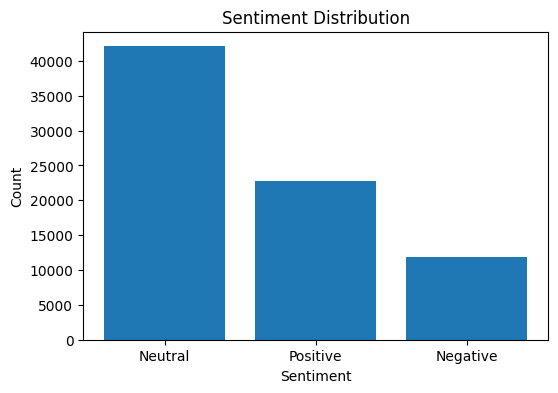

In [17]:
# Visualization of sentiments
sentiment_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

As we can see, we have the most neutral tweets. This may have a slightly bad effect on determining positive and negative moods, since our program will recognize them better than others, especially negative ones, since we have the least of them

Tweets are short messages on the social network Twitter, limited to 280 characters. They can contain text, images, videos, and links. The responses often use trends and memes, slang and abbreviations, as well as emotional expressions and relevant hashtags. Tweets are used to share news, opinions, jokes and to communicate with other users. We will process them using models tailored to the English language

In [18]:
# SpaCy english model
nlp = spacy.load("en_core_web_sm")

In [19]:
def clean_text(text):
    
    text = re.sub(r"^RT\s+", "", text)  # Remove 'RT' (re-tweets) at the beginning of the text
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (e.g., @username)
    text = re.sub(r'#', '', text)  # Remove the '#' symbol only (e.g., #hashtag)
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
    text = re.sub(r"[^A-Za-z0-9\s.]+", "", text)  # Remove special characters except periods
    text = re.sub(r"\.{2,}", " ", text)  # Replace multiple periods with a single space
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove spaces from the beginning and end of the string
    text = text.lower()  # Convert the text to lowercase
    

    # Lemmatization
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ not in ('-', '', ' ') and len(token.lemma_) > 1]  # Exclude empty lemmas, punctuation marks and single letters
    
    return " ".join(lemmas)

Text cleaning is needed for:

1.Improving Data Quality: Removing errors and noise for accurate analysis.

2.Preparing Data: Standardizing text for analysis and machine learning.

3.Simplifying Processing: Eliminating unnecessary information to streamline further work.

4.Resolving Inconsistencies: Standardizing format and style for consistency.

Lemmatization is the process of converting words into their basic or dictionary form, called a lemma. The purpose of lemmatization is to combine different forms of a word into one standard form, which helps to improve the accuracy of text analysis and reduce the size of the dictionary.

In [20]:
# Get cleaned text
df["clean_text"] = df["text"].apply(clean_text)

In [21]:
# Join all in one for using
all_text = ' '.join(df["clean_text"])

In [22]:
# Creating the word cloud while excluding stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

In [23]:
# Extract frequencies from the word cloud
word_frequencies = wordcloud.process_text(all_text) 
word_freq_counter = Counter(word_frequencies)   # sort and display word frequencies

for word, freq in word_freq_counter.most_common(30): # Display 10 words
    print(f"{word}: {freq}")

bitcoin: 34203
btc: 5713
will: 5450
go: 3974
now: 3540
crypto: 3413
new: 3069
amp: 2928
buy: 2911
people: 2803
make: 2722
time: 2649
see: 2575
one: 2556
break: 2518
say: 2338
use: 2270
today: 2189
world: 2174
money: 2133
buy bitcoin: 1900
think: 1893
need: 1883
day: 1869
bitcoin bitcoin: 1849
year: 1835
want: 1783
still: 1747
come: 1732
well: 1729


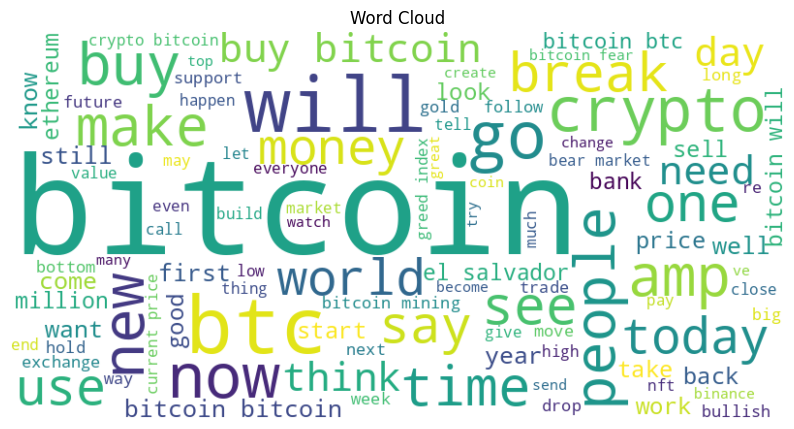

In [24]:
# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

Conclusion:

"Bitcoin" and "BTC": The overwhelming frequency of "bitcoin" and "btc" emphasizes that Bitcoin is the central topic of conversation. The repetition of "bitcoin bitcoin" suggests intense focus or emphasis on the cryptocurrency.

"Crypto": The term "crypto" being frequent alongside Bitcoin indicates discussions often encompass the broader cryptocurrency market, though Bitcoin remains the primary subject.

"Will" and "Going": These words highlight that future predictions, plans, or expectations are major themes. People are likely discussing what will happen with Bitcoin, where the market is going, and what actions to take.

"New," "Now," "Today," "Year": These terms suggest that tweets are often focused on current events, recent developments, or upcoming trends within the crypto space. There's a clear emphasis on what’s happening at the moment and how it relates to the immediate future.

"Buy," "Money," "Time": The frequent mention of "buy" and "money" suggests discussions about investing in Bitcoin, the value of money, and the timing of these investments. It implies a financial motive or interest in the economics of Bitcoin.

"First": This word could relate to milestones, achievements, or important events in the Bitcoin or cryptocurrency world, such as first-time investments, first adopters, or key events.

"People," "World," "See," "Day": These words indicate a broader discussion that involves not just technical or financial aspects but also social and global implications. Conversations may involve how Bitcoin is perceived worldwide, its impact on people's lives, and how it integrates into daily life.
Overall, these words suggest that your tweets are deeply engaged with both the current state and future possibilities of Bitcoin and the broader cryptocurrency market, with a mix of financial analysis, social implications, and global perspectives.


In [25]:
# Converting a date to a normal format
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Lets make sure that the conversion was successful
df["date"].head(3)

0   2022-01-01
1   2022-01-01
2   2022-01-01
Name: date, dtype: datetime64[ns]

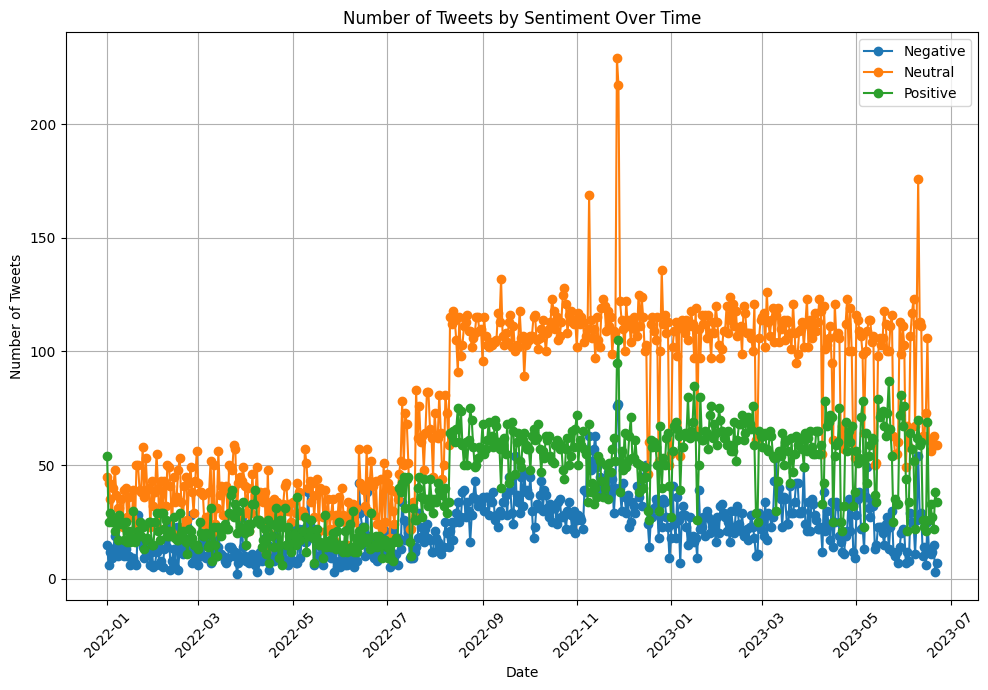

In [26]:
# Aggregating data by date and sentiment
sentiment_counts = df.groupby(["date", "sentiment_label"]).size().unstack().fillna(0).reset_index()

# Visualization
plt.figure(figsize=(10, 7))

# Plotting the number of tweets with different sentiments
for sentiment in sentiment_counts.columns[1:]:
    plt.plot(sentiment_counts["date"], sentiment_counts[sentiment], marker="o", linestyle="-", label=sentiment)

# Configuring the plot
plt.title("Number of Tweets by Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Conclusion:
The data on tweet counts shows that activity varies daily. 
Periods with a high number of tweets do not always coincide with periods when the average sentiment was higher or lower. This suggests that tweet activity does not always directly affect the overall sentiment on social media. - A sharp increase or decrease in tweet counts may correspond with specific events that influence the overall sentiment.


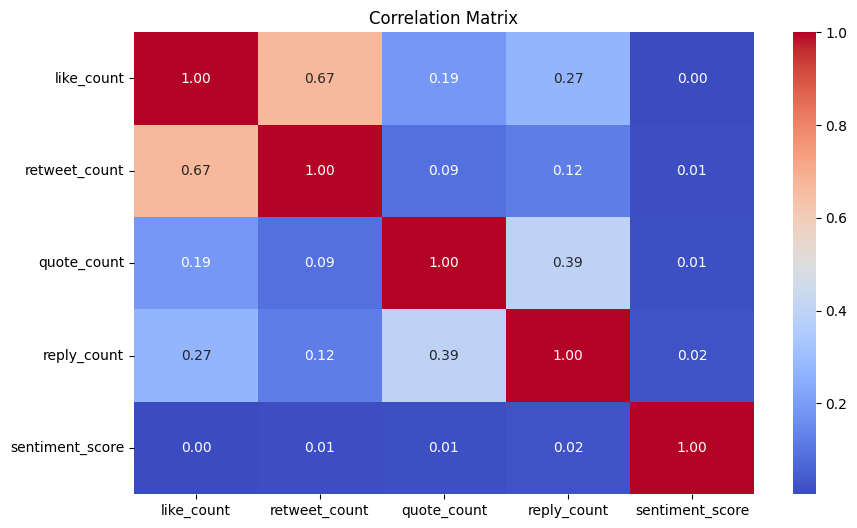

In [27]:
# Correlation matrix
correlation_matrix = df[["like_count", "retweet_count", "quote_count", "reply_count", "sentiment_score"]].corr()
# Building a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Conclusion:
There is a moderate correlation between likes and retweets, indicating that tweets with more likes tend to also have more retweets. However, there is little to no relationship between these metrics and the tweet’s sentiment or the number of times the tweet is quoted.
Retweets and quotes have a very weak relationship with each other.
Sentiment is almost independent of likes, retweets, and quotes.

These results suggest that tweet engagement metrics (likes, retweets, and quotes) are generally not strongly related to each other or to the sentiment of the tweets.
‘sentiment_score’ can be considered as an independent variable that is unlikely to be effectively predicted based on interaction data alone


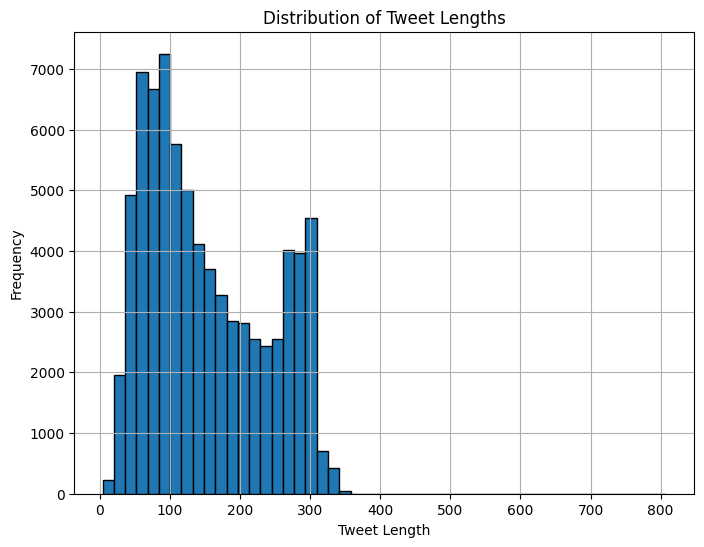

In [28]:
# Tweet length
plt.figure(figsize=(8, 6))
plt.hist(df['text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

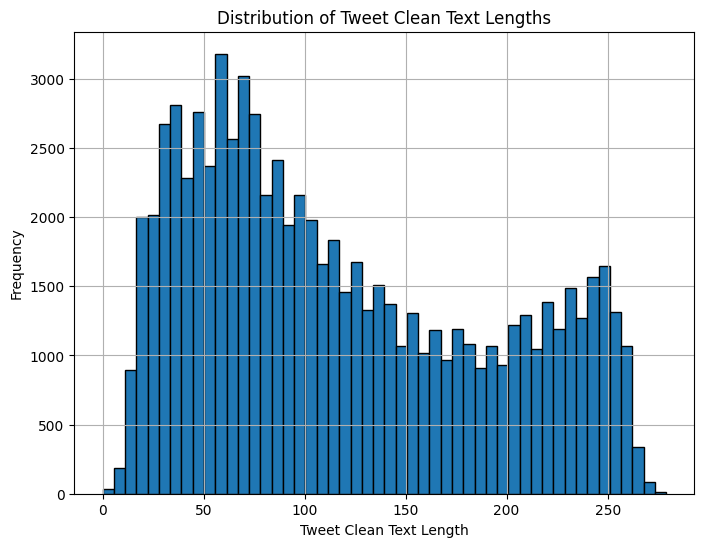

In [29]:
# Tweet length clean text
plt.figure(figsize=(8, 6))
plt.hist(df['clean_text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Clean Text Lengths")
plt.xlabel("Tweet Clean Text Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Conclusion:
The length of the cleaned tweets still varies greatly, which indicates that the cleaning has not significantly changed the distribution of tweet lengths, although it is worth recognizing that the number of abnormal tweets has significantly decreased, which will greatly facilitate our work.

# 2. Data Preprocessing and Tokenization

### 2.1 Tokenize the text data and preparation of tokenized data for input into model

In [30]:
# We conclude that the other columns do not affect anything. We remove all unnecessary columns
df = df[["clean_text", "sentiment_label"]]

We will use the latest version of RoBERTa, specially trained on tweets

In [31]:
# Load the tokenizer for the twitter-roberta-base-sentiment-latest model
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", truncation=True, do_lower_case=True)

In [33]:
# Apply tokenization to the texts
tokenized_data = tokenizer(df["clean_text"].tolist(),    # tweets
                   max_length = 64,                     # Maximum length of tokenized text
                   padding = "max_length",              # Adding padding (additional tokens) until max_length is reached
                   truncation = True,                   # Cropping the text if it is longer than max_length
                   return_tensors = "np",               # Returned NumPy tensors
                   return_attention_mask = True,       # Attention mask
                   )


input_ids = tokenized_data["input_ids"]                 # numeric representations of tokens
attention_masks = tokenized_data["attention_mask"]      # attention mask

Conclusion: This code prepares data for sentiment analysis using the RoBERTa model adapted for Twitter. It provides correct text processing (including padding and cropping), data conversion to a NumPy-compatible format, and includes attention masks to improve model performance. This makes it possible to effectively use the model to analyze sentiment based on tweets.

In [34]:
# Converting moods to numeric labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["sentiment_label"])
label = to_categorical(df["label"], num_classes=3)

To make the cat work so correctly, we will use the Datasets library. We will first need to convert our data to Dataset format, and then use methods from datasets to divide them into training, validation, and test suites.

In [35]:
# Converting labels in the Dataset format
def create_dataset(input_ids, attention_masks, labels):
    return Dataset.from_dict({
        "input_ids": list(input_ids),
        "attention_mask": list(attention_masks),
        "labels": list(labels)
    })

# Creating a Complete Dataset
dataset = create_dataset(input_ids, attention_masks, label)

Conclusion:
The Dataset format is used in machine learning and data processing libraries such as Hugging Face's datasets to simplify and standardize working with data. 
The Dataset format provides a unified interface for working with data, which simplifies their loading, preprocessing and use in models.
All data in one format makes it easier to work with data, especially when moving from one processing stage to another.

In [36]:
# Data separation
dataset_split = dataset.train_test_split(test_size=0.4, seed=42, shuffle=True)
test_valid_split = dataset_split["test"].train_test_split(test_size=0.45, seed=42, shuffle=True)

Why we separate ours data?Evaluation of the final model: After you have configured the hyperparameters of the model using KFold cross-validation on training data, you need to have an independent test set on which you can evaluate the final performance of the model. This test set should not be used during the model setup process to avoid overestimating its quality.

Hyperparameter validation: KFold-cross validation is used to select the best hyperparameters, but even for this process it is useful to divide the data into training and validation parts. For example, you can use one part of the data for cross-validation and hyperparameter selection, and the other part (validation set) to verify that the selected parameters actually work in practice.

Randomness control: Pre-partitioning the data and using a fixed test set reduces the impact of randomness on model evaluation and allows you to repeat experiments with the same data to obtain stable results.

In [37]:
# Creating a DatasetDict
datasets = DatasetDict({
    "train": dataset_split["train"],
    "validation": test_valid_split["train"],
    "test": test_valid_split["test"]

})

We have successfully converted our data into a Dataset format and divided it into training, validation and test data. We are ready to fine tune our model and train

# 3. Model Fine-Tuning

### 3.1 Fine-tune a pre-trained transformer model

We will use k-fold cross validation. It splits the data into k parts (folds) and uses each of them as a test sample, and the remaining k-1 parts to train the model. This process is repeated k times, and the model is tested on each of the parts.

In [38]:
# Initialize KFold cross-validator
kf = KFold(n_splits=1, shuffle=True, random_state=42)

In [40]:
# A function that calculates metrics such as accuracy, precision, recall, and F1-score
def compute_metrics(pred):
    labels = np.argmax(pred.label_ids, axis=-1)  
    preds = np.argmax(pred.predictions, axis=-1) 
    accuracy = accuracy_score(labels, preds)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    # Return the metrics as a dictionary
    return {
        "accuracy": accuracy,  # Accuracy of the predictions
        "precision": precision,  # Precision of the predictions
        "recall": recall,  # Recall of the predictions
        "f1": f1,  # F1-score of the predictions
    }

In [48]:
# Objective function for hyperparameter tuning with Optuna
def objective(trial):
    training_args = TrainingArguments(
        output_dir="./results",  # Directory to save the model and results
        num_train_epochs=trial.suggest_int("num_train_epochs", 1, 5),  # Number of training epochs
        learning_rate=trial.suggest_loguniform("learning_rate", 1e-5, 5e-5),  # Learning rate 
        per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),  # Batch size for training
        per_device_eval_batch_size=trial.suggest_categorical("per_device_eval_batch_size", [8, 16, 32]),  # Batch size for evaluation
        warmup_steps=trial.suggest_int("warmup_steps", 0, 1000),  # Number of warmup steps for learning rate scheduler
        weight_decay=trial.suggest_uniform("weight_decay", 0.0, 0.1),  # L2 regularization (weight decay)
        logging_dir="./logs",  # Directory for logging
        logging_steps=10,  # Logging frequency 
        evaluation_strategy="epoch",  # Evaluate after each epoch
        save_strategy="epoch",  # Save the model after each epoch
        load_best_model_at_end=True,  # Load the best model at the end of training
        metric_for_best_model="eval_loss",  # Metric to use for determining the best model
        max_grad_norm=trial.suggest_uniform("max_grad_norm", 0.5, 1.0),  # Maximum gradient norm for gradient clipping
        gradient_accumulation_steps=trial.suggest_int("gradient_accumulation_steps", 1, 4),  # Number of steps to accumulate gradients
        dataloader_num_workers=4,  # Number of workers for data loading
        run_name="none",  # Set to None or remove this line if not needed
        report_to="none",  # Disable integration with W&B and other services
    )

    # Load model with Dropout
    model = RobertaForSequenceClassification.from_pretrained(
        "cardiffnlp/twitter-roberta-base-sentiment-latest", 
        num_labels=3,  # Number of output labels
        ignore_mismatched_sizes=True,  # Ignore size mismatches if they occur
    )
    
    # Set dropout probabilities
    model.config.hidden_dropout_prob = trial.suggest_uniform("hidden_dropout_prob", 0.1, 0.3)  # Dropout probability for hidden layers
    model.config.attention_probs_dropout_prob = trial.suggest_uniform("attention_probs_dropout_prob", 0.1, 0.3)  # Dropout probability for attention layers

    # Freeze layers based on the trial's suggestion
    freeze_layers = trial.suggest_int("freeze_layers", 0, 12)  # Roberta-base with 12 layers
    for param in model.roberta.parameters():
        param.requires_grad = False  # Freeze all layers initially
    for i in range(freeze_layers, 12):
        for param in model.roberta.encoder.layer[i].parameters():
            param.requires_grad = True  # Unfreeze specified layers

    avg_eval_loss = 0
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(df):
        train_df, test_df = df.iloc[train_index], df.iloc[test_index]
        train_labels = to_categorical(train_df["label"], num_classes=3)  # Convert labels to categorical format
        test_labels = to_categorical(test_df["label"], num_classes=3)

        # Tokenize the text data
        tokenized_train_data = tokenizer(train_df["clean_text"].tolist(), max_length=64, padding="max_length", truncation=True, return_tensors="np")
        tokenized_test_data = tokenizer(test_df["clean_text"].tolist(), max_length=64, padding="max_length", truncation=True, return_tensors="np")

        # Create datasets
        train_dataset = create_dataset(tokenized_train_data["input_ids"], tokenized_train_data["attention_mask"], train_labels)
        test_dataset = create_dataset(tokenized_test_data["input_ids"], tokenized_test_data["attention_mask"], test_labels)
        
        # Initialize Trainer with the specified arguments and datasets
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping callback
        )

        # Train the model
        trainer.train()
        eval_results = trainer.evaluate()  # Evaluate the model
        avg_eval_loss += eval_results["eval_loss"]  # Accumulate evaluation loss

    avg_eval_loss /= kf.get_n_splits()  # Compute average evaluation loss

    # Save the model if it's the best so far
    trial.set_user_attr("model_path", "./best_model_trial_{}".format(trial.number))
    trainer.save_model(trial.user_attrs["model_path"])

    return avg_eval_loss  # Return the average evaluation loss

To combat overfitting, we will use the Drop out late, the nature of which we will set using hyperparameters. It will be a good practice to freeze layers, since RoBERTa model can be very powerful, which is why it will not produce the result we need on our data

In [ ]:
# Perform Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

In [50]:
# Best parameters
study.best_params

Best hyperparameters:  {'num_train_epochs': 3, 'learning_rate': 2.3311031477348052e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'warmup_steps': 630, 'weight_decay': 0.05180266162382893, 'max_grad_norm': 0.5757268880209764, 'gradient_accumulation_steps': 1, 'hidden_dropout_prob': 0.20787227376469775, 'attention_probs_dropout_prob': 0.2880938516824848, 'freeze_layers': 7}


In [52]:
# After optimization
best_trial = study.best_trial

# Path for the best model
best_model_path = best_trial.user_attrs["model_path"]

Conclusion:
This code performs automated configuration of hyperparameters of the RoBERTa For SequenceClassificationmodel using the Optuna library and k-fold cross-validation.
- Optuna offers hyperparameter values such as the number of epochs, learning rate, batch size, and other model and learning parameters.
- The RobertaForSequenceClassification model is set with the ability to adjust Dropout layers and freeze layers.
- Data is divided into training and test sets using k-fold cross validation. The model is trained and evaluated on each partition.
- The average loss (eval_loss) is calculated for all folds. If the current model is the best, it is saved.


In [53]:
best_params = study.best_params

# 4. Model Evaluation and Interpretation

### 4.1 Train and evaluation

As we remember, we saved our data in the ‘best_params’ variable, from where we should get our data about the best model. Now we just need to transfer them to our model

In [54]:
# Final model with optimized dropout values and layer freezes
# Download the best model
final_model = RobertaForSequenceClassification.from_pretrained(best_model_path, # OUR BEST MODEL
                                                                 num_labels=3,
                                                               ignore_mismatched_sizes=True)
final_model.config.hidden_dropout_prob = best_params["hidden_dropout_prob"]
final_model.config.attention_probs_dropout_prob = best_params["attention_probs_dropout_prob"]

In [55]:
# Freezing layers from best parameters
freeze_layers = best_params["freeze_layers"]
for param in final_model.roberta.parameters():
    param.requires_grad = False
for i in range(freeze_layers, 12):
    for param in final_model.roberta.encoder.layer[i].parameters():
        param.requires_grad = True

In [56]:
final_training_args = TrainingArguments(
    output_dir="./results",  # Save model/results
    num_train_epochs=best_params["num_train_epochs"],  # Optimized epochs
    learning_rate=best_params["learning_rate"],  # Optimized learning rate
    per_device_train_batch_size=best_params["per_device_train_batch_size"],  # Optimized train batch
    per_device_eval_batch_size=best_params["per_device_eval_batch_size"],  # Optimized eval batch
    warmup_steps=best_params["warmup_steps"],  # Optimized warmup
    weight_decay=best_params["weight_decay"],  # Optimized weight decay
    logging_dir="./logs",  # Log directory
    logging_steps=10,  # Log frequency
    evaluation_strategy="epoch",  # Evaluate each epoch
    save_strategy="epoch",  # Save each epoch
    load_best_model_at_end=True,  # Load best model
    metric_for_best_model="eval_loss",  # Best model metric
    max_grad_norm=best_params["max_grad_norm"],  # Optimized grad norm
    gradient_accumulation_steps=best_params["gradient_accumulation_steps"],  # Optimized gradient accumulation
    dataloader_num_workers=4,  # Data loader workers
    run_name="none",  # No run name
    report_to="none",  # No reporting
)

In [58]:
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Early stopping
)

In [59]:
# Model training
final_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.253900,0.151142,0.902909,0.911117,0.902909,0.903328
2,0.264300,0.166713,0.892957,0.904343,0.892957,0.893386
3,0.252300,0.148731,0.908359,0.915537,0.908359,0.908765


TrainOutput(global_step=4317, training_loss=0.23853535389276134, metrics={'train_runtime': 1062.9482, 'train_samples_per_second': 129.94, 'train_steps_per_second': 4.061, 'total_flos': 4542653157073920.0, 'train_loss': 0.23853535389276134, 'epoch': 3.0})

Conclusion:

-The model shows improvement in validation loss from Epoch 1 to Epoch 3 (from 0.151142 to 0.148731), indicating that the model is learning and generalizing better over time.

-Accuracy and F1-score both improve from Epoch 2 to Epoch 3, suggesting that the model's predictions are becoming more consistent with the true labels.

-The slight dip in these metrics from Epoch 1 to Epoch 2 might indicate temporary overfitting or noise, but the improvement in Epoch 3 suggests recovery.

-Precision and recall are fairly stable across epochs, with a slight increase in Epoch 3, which shows the model maintains a balance between false positives and false negatives. 

-The model appears to be converging, with the best performance observed at Epoch 3, as indicated by the lowest validation loss and highest accuracy, precision, recall, and F1-score.

Overall, the tuned hyperparameters led to an effective model that generalizes well to unseen data, as evidenced by the strong validation performance in the final epoch.


In [82]:
# Prediction
predictions = final_trainer.predict(datasets['test'])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = np.argmax(predictions.label_ids, axis=1)

In [83]:
# Classifiction report
print(classification_report(true_labels, preds, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.85      0.96      0.90      2121
     neutral       0.97      0.87      0.92      7648
    positive       0.85      0.96      0.90      4044

    accuracy                           0.91     13813
   macro avg       0.89      0.93      0.91     13813
weighted avg       0.92      0.91      0.91     13813



Conclusion:
The model does a good job of classifying reviews into neutral and positive, but has some problems with accuracy in classifying negative reviews and completeness for positive ones.
The Neutral class has the best performance across all metrics, which may indicate that the model is better trained for this class or that this class prevails in the data.
The micro avg and weighted avg indicators confirm that the model is generally balanced, although there are minor differences between classes.


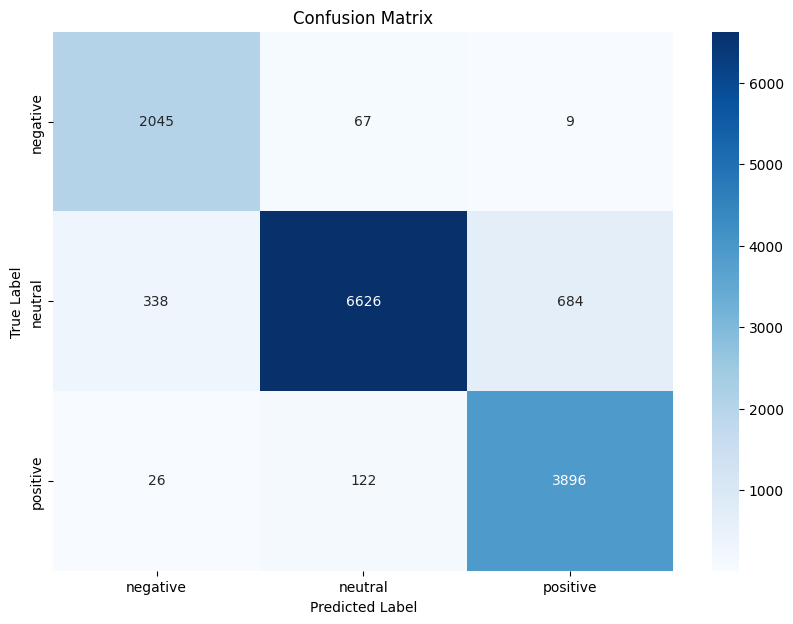

array([[2045,   67,    9],
       [ 338, 6626,  684],
       [  26,  122, 3896]])

In [84]:
# Confusion matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
cm

Class Negative:

The model performs well in predicting Class Negative, with 2045 trues.
Misclassifications are relatively low, with 67 instances being incorrectly classified as Class Neutral and 9 as Class Positive.

Class Neutral:

The model shows strong performance for Class Neutral, with 6626 trues.
However, there are 338 instances of Class Neutral being misclassified as Class Negative and 684 as Class Positive, indicating some confusion primarily with Class Positive.
Class Positive:

Class Positive predictions are also strong, with 3896 trues.
There are 122 instances of Class Positive incorrectly predicted as Class Neutral and only 26 as Class Negative, showing minimal confusion with Class Negative but some with Class Neutral.
Overall:
The model performs well across all classes, with the highest accuracy for Class Neutral but some confusion between Class Neutral and Class Positive. The misclassifications are relatively low, suggesting that the model is generally effective in distinguishing between the three classes.

In [85]:
# Create Dataframe
df_results = pd.DataFrame({
    'True Labels': true_labels,
    'Predictions': preds
})

# Show
df_results

,True Labels,Predictions
0,1,1
1,2,2
2,2,2
3,1,2
4,0,0
...,...,...
13808,0,0
13809,2,2
13810,2,2
13811,2,2


In [86]:
# Correct and incorrect prediction
correct_predictions = (df_results['True Labels'] == df_results['Predictions']).sum()
total_predictions = df_results.shape[0]
accuracy = (correct_predictions / total_predictions) * 100
error_rate = 100 - accuracy

# Result
print(f'Accuracy: {accuracy:.2f}%')
print(f'Error Rate: {error_rate:.2f}%')

Accuracy: 90.98%
Error Rate: 9.02%


Conclusion:
We successfully trained our model using hyperparameters, tested it on validation data and then later on test data. The result on the test data was 90%. We have successfully uploaded our model to Hugging Face and now we can always use it for our calculations

In [ ]:
# Save our model
final_model.save_pretrained("/kaggle/working/poitreqm-model-sentiment")
tokenizer.save_pretrained("/kaggle/working/poitreqm-tokenizer-sentiment")

In [ ]:
# Specify the path to the saved model and tokenize
model_directory = "/kaggle/working/poitreqm-model-sentiment"

# repo Hugging Face
repository_name = "Poitreqm/poitreqm-model-sentiment-tweets"

# create repo
api = HfApi()
api.create_repo(repo_id=repository_name)

# upload model
final_model.push_to_hub(repository_name)
tokenizer.push_to_hub(repository_name)

Conclusion:
We successfully trainers our model using hyperparameters, tested it on validation data and then later on test data. The result on the test data was 90%. We have successfully uploaded our model to Hugging Face and now we can always use it for our calculations


# 5. Application of the model and recommendations

### 5.1 Twitter API request

We will need to create our hugging face token

In [ ]:
# # token from Hugging Face
# token = ""
# login(token)


In [ ]:
# # Specify the path to the saved model and tokenize
# model_directory = "/kaggle/working/poitreqm-model-sentiment"
# # Specify the repository name on Hugging Face
# repository_name = "Poitreqm/poitreqm-model-sentiment-tweets"

# # repo on Hugging Face
# api = HfApi()
# api.create_repo(repo_id=repository_name)

# # Gooo
# final_model.push_to_hub(repository_name)
# tokenizer.push_to_hub(repository_name)

Applying the model and getting new data

In [ ]:
# # Tweepy with
# client = tweepy.Client(
#     bearer_token=BEARER_TOKEN,
#     consumer_key=API_KEY,
#     consumer_secret=API_KEY_SECRET,
#     access_token=ACCESS_TOKEN,
#     access_token_secret=ACCESS_TOKEN_SECRET
# )

In [ ]:
# # Request to Twitter API
# def fetch_tweets(query, count):
#     tweets = tweepy.Paginator(client.search_recent_tweets, 
#                                        query=query,
#                                        tweet_fields=["created_at", "text"],
#                                        max_results=100
#                                        ).flatten(limit=count)
#     tweets_list = [[tweet.created_at, tweet.text] for tweet in tweets]
#     return pd.DataFrame(tweets_list, columns=["timestamp", "text"])

# # Save
# df = fetch_tweets("#Bitcoin", 1000) # 1000 tweets
# df.to_csv("big-files/crypto_tweets.csv", index=False)

Conclusion: This request will allow us to pull out 1000 tweets and save them in the crypto_tweets.csv file

In [87]:
# Tweets
tweets = pd.read_csv("crypto_tweets.csv")
tweets

,timestamp,text
0,2024-08-12 14:34:48+00:00,@rovercrc #Bitcoin will retrace to $70K fast. ...
1,2024-08-12 14:34:48+00:00,RT @AirdropNinjaPro: New Airdrop: FatGuy✅️\nRe...
2,2024-08-12 14:34:48+00:00,"RT @rovercrc: There is no reason to panic, thi..."
3,2024-08-12 14:34:47+00:00,@TO Chads 🟧🟧🟧🟧🟧!\n#bitcoin
4,2024-08-12 14:34:47+00:00,$DBR DeBridge #Airdrop is already here 👇\n\n#...
...,...,...
995,2024-08-12 14:28:04+00:00,"RT @WatcherGuru: JUST IN: Celsius sues Tether,..."
996,2024-08-12 14:28:03+00:00,RT @cex_io: 😳 Did you know that more and more ...
997,2024-08-12 14:28:03+00:00,RT @cex_io: 🤔 Bit...what? #Bitcoin!\n\n⚡️ Ever...
998,2024-08-12 14:28:03+00:00,@RyuK980 Telegram'daki özel mentorluk programı...


In [88]:
# Clean
tweets['clean_text'] = tweets['text'].apply(clean_text)

In [89]:
tweets

,timestamp,text,clean_text
0,2024-08-12 14:34:48+00:00,@rovercrc #Bitcoin will retrace to $70K fast. ...,bitcoin will retrace to 70k fast bear will eve...
1,2024-08-12 14:34:48+00:00,RT @AirdropNinjaPro: New Airdrop: FatGuy✅️\nRe...,new airdrop fatguy reward 10 worth of fatguy n...
2,2024-08-12 14:34:48+00:00,"RT @rovercrc: There is no reason to panic, thi...",there be no reason to panic this bitcoin bull ...
3,2024-08-12 14:34:47+00:00,@TO Chads 🟧🟧🟧🟧🟧!\n#bitcoin,chad bitcoin
4,2024-08-12 14:34:47+00:00,$DBR DeBridge #Airdrop is already here 👇\n\n#...,dbr debridge airdrop be already here nft art n...
...,...,...,...
995,2024-08-12 14:28:04+00:00,"RT @WatcherGuru: JUST IN: Celsius sues Tether,...",just in celsius sue tether demand 2.4 billion ...
996,2024-08-12 14:28:03+00:00,RT @cex_io: 😳 Did you know that more and more ...,do you know that more and more people worldwid...
997,2024-08-12 14:28:03+00:00,RT @cex_io: 🤔 Bit...what? #Bitcoin!\n\n⚡️ Ever...,bit what bitcoin ever wonder how it work check...
998,2024-08-12 14:28:03+00:00,@RyuK980 Telegram'daki özel mentorluk programı...,telegramdaki zel mentorluk programna katlma ve...


In [ ]:
# 'your_username/repo_name'
model_name = "Poitreqm/poitreqm-model-sentiment-tweets"

# Download model 
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Download tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [90]:
# Tokenizing text
tokenized_tweets_pred = tokenizer(tweets['clean_text'].tolist(),
                             max_length=64,  # Need the same line like in train
                             padding='max_length',
                             truncation=True,
                             return_tensors='np',
                             return_attention_mask=True)

# input_ids and attention_mask
input_ids_pred = tokenized_tweets_pred['input_ids']
attention_masks_pred = tokenized_tweets_pred['attention_mask']

In [91]:
# Our Argiments
tweet_pred_args = TrainingArguments(
    output_dir="./results",
    run_name="none",  
    report_to="none",  
)

In [92]:
# Our trainer
trainer = Trainer(model=model,
                 args=tweet_pred_args,)

In [93]:
# Encoding labels
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["negative", "neutral", "positive"])

Conclusion:
As we can see, we have to put our new tweets through the same process that we did with our training data: cleanup, tokenization, fine-tuning and training.

In [94]:
# Transform in Dataset format
def create_dataset(input_ids, attention_masks):
    dataset_dict = {
        "input_ids": list(input_ids),
        "attention_mask": list(attention_masks),
    }
    
    return Dataset.from_dict(dataset_dict)

In [95]:
# Create Dataset
dataset = create_dataset(input_ids_pred, attention_masks_pred)

In [96]:
# Prediction
predictions = trainer.predict(dataset)
preds = np.argmax(predictions.predictions, axis=1)

In [97]:
# Transforming our labels in normal type
predicted_labels = label_encoder.inverse_transform(preds)

In [98]:
# Adding predictions to the DataFrame
tweets['predicted_sentiment'] = predicted_labels

In [99]:
# Check for missing values
tweets.isnull().sum()

timestamp              0
text                   0
clean_text             0
predicted_sentiment    0
dtype: int64

In [100]:
# Check for duplicates and non-dublicates
tweets.duplicated().value_counts()

False    997
True       3
Name: count, dtype: int64

In [101]:
# Remove duplicates
tweets = tweets.drop_duplicates()

In [102]:
tweets

,timestamp,text,clean_text,predicted_sentiment
0,2024-08-12 14:34:48+00:00,@rovercrc #Bitcoin will retrace to $70K fast. ...,bitcoin will retrace to 70k fast bear will eve...,neutral
1,2024-08-12 14:34:48+00:00,RT @AirdropNinjaPro: New Airdrop: FatGuy✅️\nRe...,new airdrop fatguy reward 10 worth of fatguy n...,neutral
2,2024-08-12 14:34:48+00:00,"RT @rovercrc: There is no reason to panic, thi...",there be no reason to panic this bitcoin bull ...,positive
3,2024-08-12 14:34:47+00:00,@TO Chads 🟧🟧🟧🟧🟧!\n#bitcoin,chad bitcoin,neutral
4,2024-08-12 14:34:47+00:00,$DBR DeBridge #Airdrop is already here 👇\n\n#...,dbr debridge airdrop be already here nft art n...,neutral
...,...,...,...,...
995,2024-08-12 14:28:04+00:00,"RT @WatcherGuru: JUST IN: Celsius sues Tether,...",just in celsius sue tether demand 2.4 billion ...,neutral
996,2024-08-12 14:28:03+00:00,RT @cex_io: 😳 Did you know that more and more ...,do you know that more and more people worldwid...,positive
997,2024-08-12 14:28:03+00:00,RT @cex_io: 🤔 Bit...what? #Bitcoin!\n\n⚡️ Ever...,bit what bitcoin ever wonder how it work check...,neutral
998,2024-08-12 14:28:03+00:00,@RyuK980 Telegram'daki özel mentorluk programı...,telegramdaki zel mentorluk programna katlma ve...,neutral


In [103]:
tweets["predicted_sentiment"].value_counts()

predicted_sentiment
neutral     671
positive    252
negative     74
Name: count, dtype: int64

### 5.2 Recommendations

To improve our model, consider the following steps: 

Increase the amount of data: 
Collect more data or apply data augmentation. This will help the model better identify patterns and improve its performance. 

Using linear regression instead of classification: 
If the task requires an assessment of degree or intensity, rather than a simple assignment of classes, try linear regression. This will allow you to obtain quantitative estimates and probabilities. 

Applying multiple models: 
Combining different algorithms can improve the accuracy and reliability of predictions.

Expanding the range of responses: 
Switch to five classes (negative, neutral-negative, neutral, neutral-positive, positive) to better reflect the gradations in the data. Update the loss function and evaluation metrics for a multi-class task.

Increase Cross-validation and Hyperparameters
The increased capacity will allow us to use more parameters in cross-validation and hyperparameters, which in turn will allow a better model.
